In [2]:
#load libraries
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
import scipy.spatial.distance as distance
import statsmodels.stats.multitest as multitest
from folktables import ACSDataSource
import statsmodels.api as sm


\begin{align*}
&U_{xz} \leftarrow Uniform(0,1)\\
&X \leftarrow 1\{U_{xz} < 0.5\}\\
&Z \leftarrow 1\{U_{xz} < 0.75\}\\
&W \leftarrow Bernoulli(\frac{3}{10}(X+Z)+\frac{1}{10})\\
&Y \leftarrow Bernoulli(\frac{3}{10}(X+Z)+\frac{1}{4}W + \frac{1}{10})\\
\end{align*}


In [6]:
#create the sample scm

def hiring_data(shift, n=50000,d=0.1):
    
    np.random.seed(0)
    
    U = np.random.normal(0, 1, n)
    X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
    Y = np.random.binomial(1,(3/10)*(X+Z)+(1/4)*W+0.05,n)
    sample_1 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    if shift == 1:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(3/10)*(X+Z)+(1/4)*W + 0.05 + d,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    else:       
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(3/10)*(X+Z)+(1/4)*W+0.05,n)

        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    return sample_1, sample_2

sample_1, sample_2 = hiring_data(0)
_ , sample_3 = hiring_data(1)




In [7]:
#Compute Total Variation and x-specific decomposition
def compute_total_variation(sample):
    #compute the total variation E[Y=1|X=1] - E[Y=1|X=0]
    total_variation = sample[sample['X']==1]['Y'].mean() - sample[sample['X']==0]['Y'].mean()
    #compute the x-specific decomposition
    x_de = 0
    x_ie = 0
    x_se = 0
    for z in [0,1]:
        for w in [0,1]:
            
            #Compute all needed probabilities
            #P(Y=1|X=1,Z,W)
            p_y1_x1_zw = sample[(sample['X']==1) & (sample['Z']==z) & (sample['W']==w)]['Y'].mean()
            #P(Y=1|X=0,Z,W)
            p_y1_x0_zw = sample[(sample['X']==0) & (sample['Z']==z) & (sample['W']==w)]['Y'].mean()
            #P(W=w|X=1,Z=z)
            if sample[(sample['X']==1) & (sample['Z']==z)].shape[0] == 0:
                p_w_w_x1_z = 0
                continue
            else:
                p_w_w_x1_z = sample[(sample['X']==1) & (sample['Z']==z) & (sample['W']==w)].shape[0]/sample[(sample['X']==1) & (sample['Z']==z)].shape[0]
            #P(W=w|X=0,Z=z)
            p_w_w_x0_z = sample[(sample['X']==0) & (sample['Z']==z) & (sample['W']==w)].shape[0]/sample[(sample['X']==0) & (sample['Z']==z)].shape[0]
            #P(Z=z|X=1)
            p_z_z_x1 = sample[(sample['X']==1) & (sample['Z']==z)].shape[0]/sample[sample['X']==1].shape[0]
            #P(Z=z|X=0)
            p_z_z_x0 = sample[(sample['X']==0) & (sample['Z']==z)].shape[0]/sample[sample['X']==0].shape[0]

            #Compute the x-specific decomposition
            x_de += (p_y1_x1_zw - p_y1_x0_zw)*p_w_w_x0_z*p_z_z_x0
            x_ie += (p_w_w_x0_z - p_w_w_x1_z)*p_y1_x1_zw*p_z_z_x0
            x_se += (p_z_z_x0 - p_z_z_x1)*p_y1_x1_zw*p_w_w_x1_z


    return np.round(total_variation,4), np.round(x_de,4), np.round(x_ie,4), np.round(x_se,4)

#Compute the total variation and x-specific decomposition for each sample
sample_1_tv, sample_1_de, sample_1_ie, sample_1_se = compute_total_variation(sample_1)
sample_2_tv, sample_2_de, sample_2_ie, sample_2_se = compute_total_variation(sample_2)
sample_3_tv, sample_3_de, sample_3_ie, sample_3_se = compute_total_variation(sample_3)

#Print the results
print(f"Sample 1: Total Variation = {sample_1_tv}, DE = {sample_1_de}, IE = {sample_1_ie}, SE = {sample_1_se}")
print(f"Sample 2: Total Variation = {sample_2_tv}, DE = {sample_2_de}, IE = {sample_2_ie}, SE = {sample_2_se}")
print(f"Sample 3: Total Variation = {sample_3_tv}, DE = {sample_3_de}, IE = {sample_3_ie}, SE = {sample_3_se}")



Sample 1: Total Variation = 0.4415, DE = 0.3015, IE = -0.0746, SE = -0.0653
Sample 2: Total Variation = 0.4441, DE = 0.3022, IE = -0.0748, SE = -0.067
Sample 3: Total Variation = 0.4421, DE = 0.2998, IE = -0.0743, SE = -0.068


In [8]:
#Define function to perform weighted bootstrap test
def weighted_outcomes_bootstrap_test_schrouff(sample_a,sample_b, causal_parents_source, B=10000, split=0.75):

    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty(B)
    bootstrapped_mean_probabilities = np.empty(B)
    bootstrapped_weights_mean = np.empty((2,B))
    bootstrapped_weighted_outcome = np.empty((2,B))
    bootstrapped_pooled_se = np.empty(B)

    #Step2: perform bootstrap
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
        #Test, for each bootstrap iteration have a different set for weights and testing
        #Step 2.1: Sample with replacement from the weights and testing
        bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
        bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
        bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
        bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

        #Step 2.2: Fit logistic regression model to estimate weights
        ##Pool the samples
        pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
        ##Add sample indicator
        pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
        ##Feature matrix X with intercept
        X = sm.add_constant(pooled_weights[causal_parents_source])
        ##Target vector Y with sample 1 as reference
        Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
        ##Fit logistic regression model
        logit_model = sm.Logit(Y, X).fit(disp=0)
        ##extract weights on testing set
        X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
        X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
        p_a = logit_model.predict(X_a)
        p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
        p_b = logit_model.predict(X_b)
        #Store the mean probability for p_a
        bootstrapped_mean_probabilities[i] = np.mean(p_a)
        if np.any(p_a == 0) or np.any(p_b == 0):
            print('Warning: Zero values in p_a or p_b')
        if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
            print('Warning: Near-zero values in p_a or p_b')
        #Compute the weights
        w_a = 1/p_a
        w_b = 1/p_b
        #Normalize the weights
        w_a_norm = w_a/np.sum(w_a)
        w_b_norm = w_b/np.sum(w_b)
        #Check for nans and infs
        if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
            print('Warning: NaN values in w_a or w_b')
        if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
            print('Warning: Inf values in w_a or w_b')
        #Check for very small values
        if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
            print('Warning: Near-zero values in w_a or w_b')
        
        #Compute hadamard product
        Y_a = bootstrap_sample_a_testing['Y'].values
        Y_b = bootstrap_sample_b_testing['Y'].values
        product_a = w_a_norm.values*Y_a
        product_b = w_b_norm.values*Y_b
        together = np.concatenate([product_a,-product_b])
        bootstrapped_t_stats[i] = ttest_1samp(together, 0)[0]
        #Compute and store weighted means
        bootstrapped_weighted_outcome[0,i] = np.sum(product_a)
        bootstrapped_weighted_outcome[1,i] = np.sum(product_b)
        #Compute and store mean weights
        bootstrapped_weights_mean[0,i] = np.mean(w_a)
        bootstrapped_weights_mean[1,i] = np.mean(w_b)

    #Step 3: Compute p-values
    mean = np.mean(bootstrapped_t_stats)
    std = np.std(bootstrapped_t_stats)
    p_value = (2*norm.cdf(-abs(mean/std)))

    return bootstrapped_t_stats, p_value,bootstrapped_weighted_outcome,bootstrapped_mean_probabilities, bootstrapped_weights_mean


#Perform the test for sample 1 vs sample 2
##anotate the causal parents
causal_parents_source_y = ['X','Z','W']
causal_parents_source_x,causal_parents_source_z = [],[]
causal_parents_source_w  =["X","W"]
##run test
##for y
no_shift_t_stats_y, p_value_y,weighted_means_y,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_y, B = 5000, split = 0.75)
##for w 
no_shift_t_stats_w, p_value_w,weighted_means_w,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_w, B = 5000, split = 0.75)
##for x
no_shift_t_stats_x, p_value_x,weighted_means_x,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_x, B = 5000, split = 0.75)
##for z
no_shift_t_stats_z, p_value_z,weighted_means_z,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_z, B = 5000, split = 0.75)

Bootstrapping: 100%|██████████| 5000/5000 [02:26<00:00, 34.06it/s]


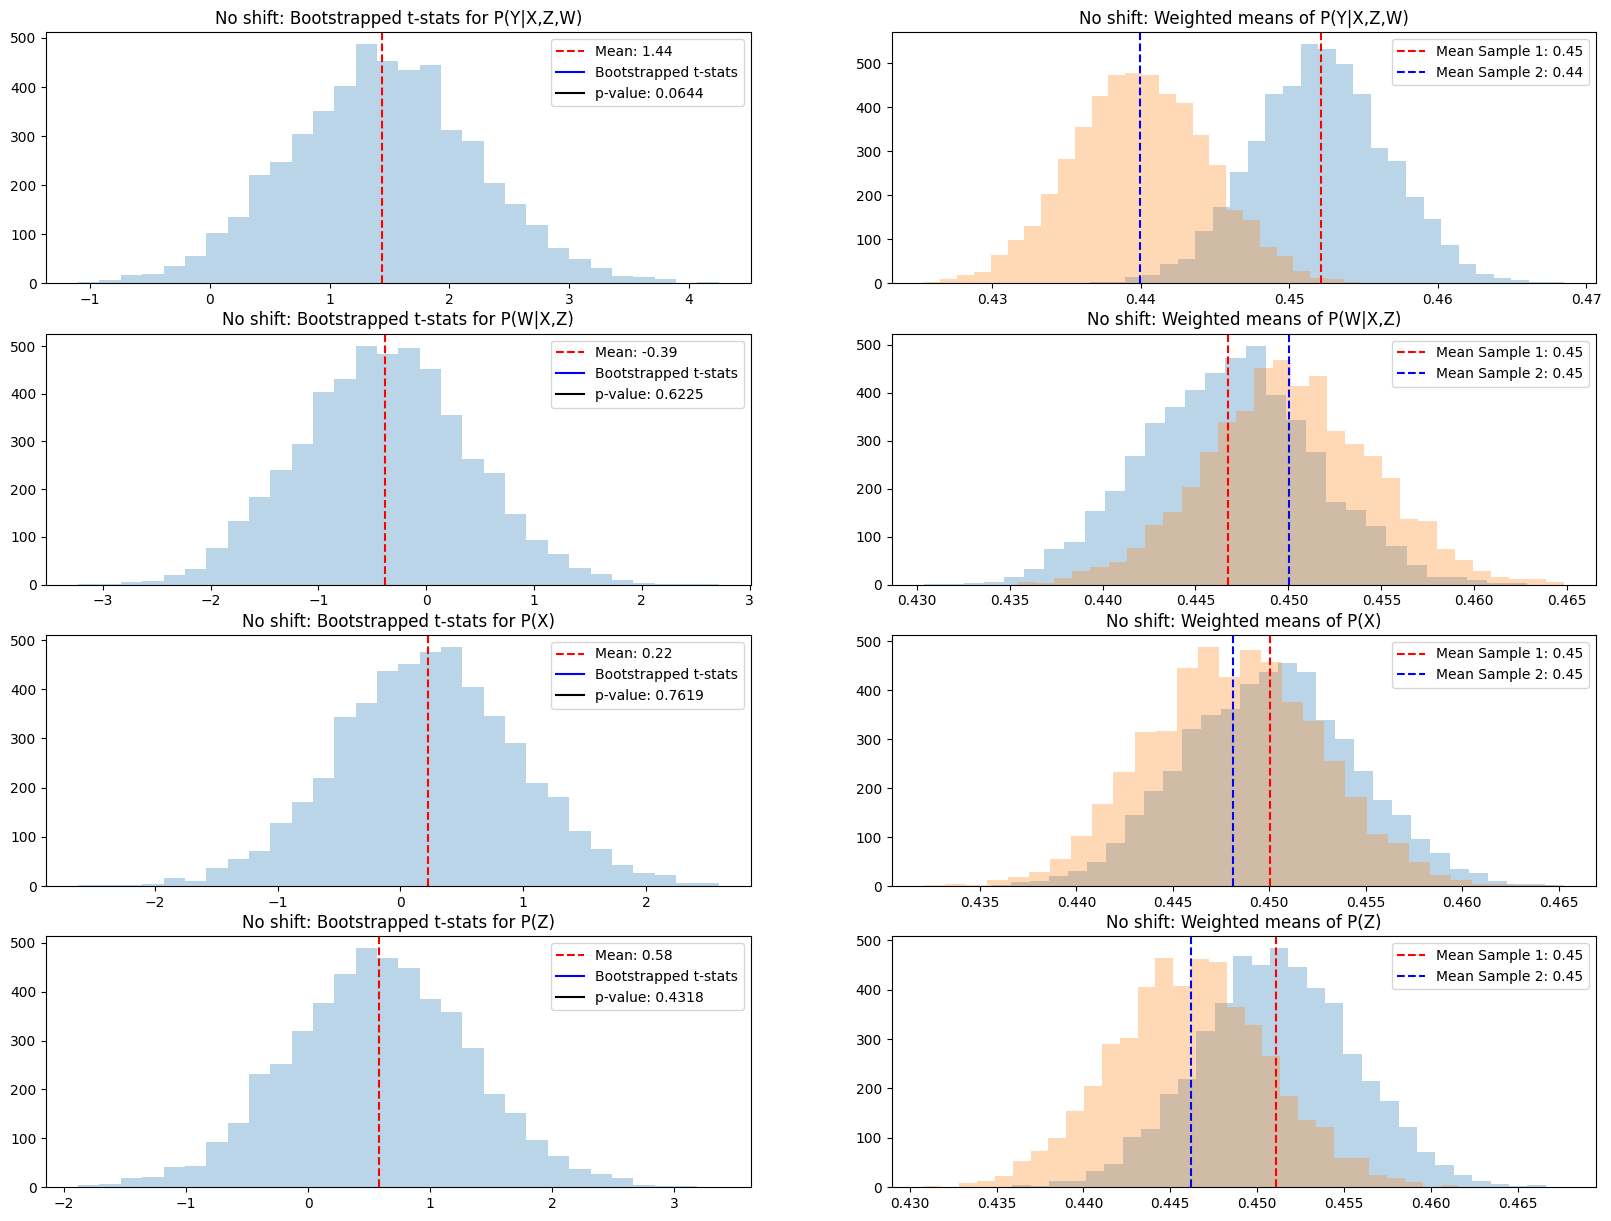

<Figure size 640x480 with 0 Axes>

In [11]:
#Give histogram of t-stats and weighted means for each test
tests = ["P(Y|X,Z,W)", "P(W|X,Z)", "P(X)", "P(Z)"]
t_stats = [no_shift_t_stats_y, no_shift_t_stats_w, no_shift_t_stats_x, no_shift_t_stats_z]
weighted_means = [weighted_means_y, weighted_means_w, weighted_means_x, weighted_means_z]
p_values = [p_value_y, p_value_w, p_value_x, p_value_z]

fig, axs = plt.subplots(4,2, figsize=(20,15))
for i in range(4):
    axs[i,0].hist(t_stats[i], bins=30, label='Bootstrapped t-stats', alpha = 0.3)
    axs[i,0].set_title(f'No shift: Bootstrapped t-stats for {tests[i]}')
    axs[i,0].axvline(x=np.mean(t_stats[i]), color='r', linestyle='--', label='Mean')
    #Add p-value without color coding
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean: {np.round(np.mean(t_stats[i]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='-', label="Bootstrapped t-stats")]
    axs[i,0].legend(handles=handles + [plt.Line2D([0], [0], color='black', linestyle='-', label=f'p-value: {np.round(p_values[i],4)}')])
    axs[i,1].hist(weighted_means[i][0], bins=30, label='Sample 1', alpha = 0.3)
    axs[i,1].hist(weighted_means[i][1], bins=30, label='Sample 2', alpha = 0.3)
    axs[i,1].set_title(f'No shift: Weighted means of {tests[i]}')
    axs[i,1].axvline(x=np.mean(weighted_means[i][0]), color='r', linestyle='--', label='Mean Sample 1')
    axs[i,1].axvline(x=np.mean(weighted_means[i][1]), color='b', linestyle='--', label='Mean Sample 2')
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean Sample 1: {np.round(np.mean(weighted_means[i][0]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='--', label=f'Mean Sample 2: {np.round(np.mean(weighted_means[i][1]),2)}')]
    axs[i,1].legend(handles=handles)

plt.show()
plt.tight_layout()


No rejected nulls !! Everything good? No, lets slightly perturb the SCM

In [16]:
#_, sample_3_low_d = hiring_data(1, n = 50000,  d=0.02)
_, sample_3_low_n = hiring_data(1, n = 1000,  d=0.03)

#perform the test for sample 1 vs sample 3 only for P(Y|X,Z,W)
##for y
#shift_t_stats_y, p_value_y,weighted_means_y,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3_low_d, causal_parents_source_y, B = 5000, split = 0.75)
shift_t_stats_y_low_n, p_value_y_low_n,weighted_means_y_low_n,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3_low_n, causal_parents_source_y, B = 5000, split = 0.75)

Bootstrapping: 100%|██████████| 5000/5000 [03:29<00:00, 23.86it/s]


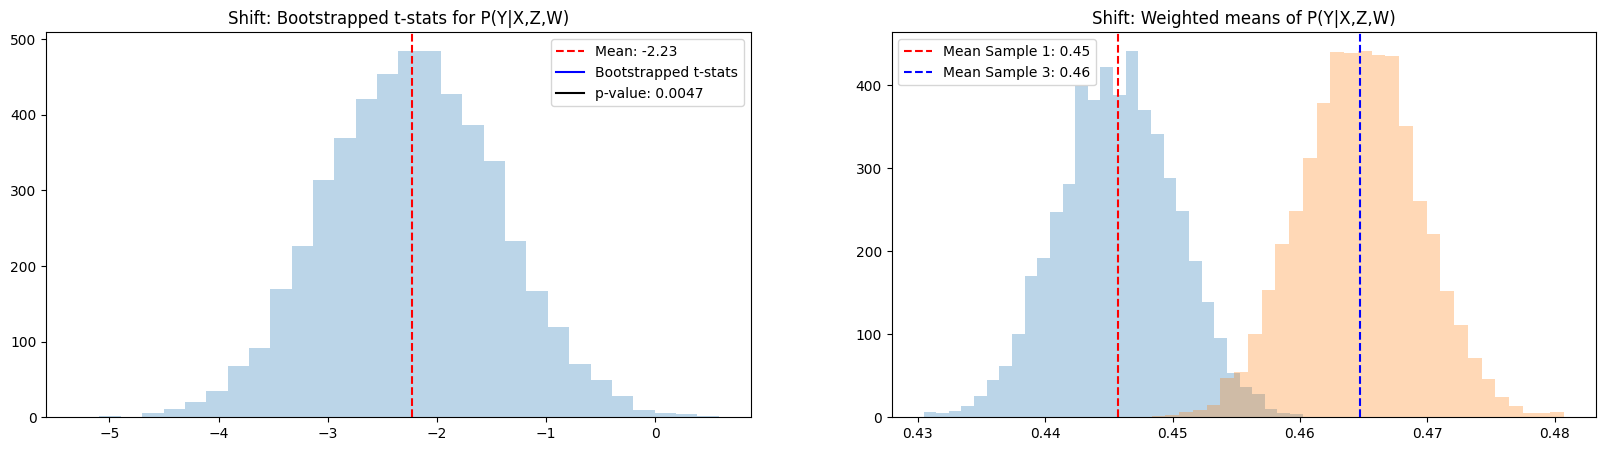

<Figure size 640x480 with 0 Axes>

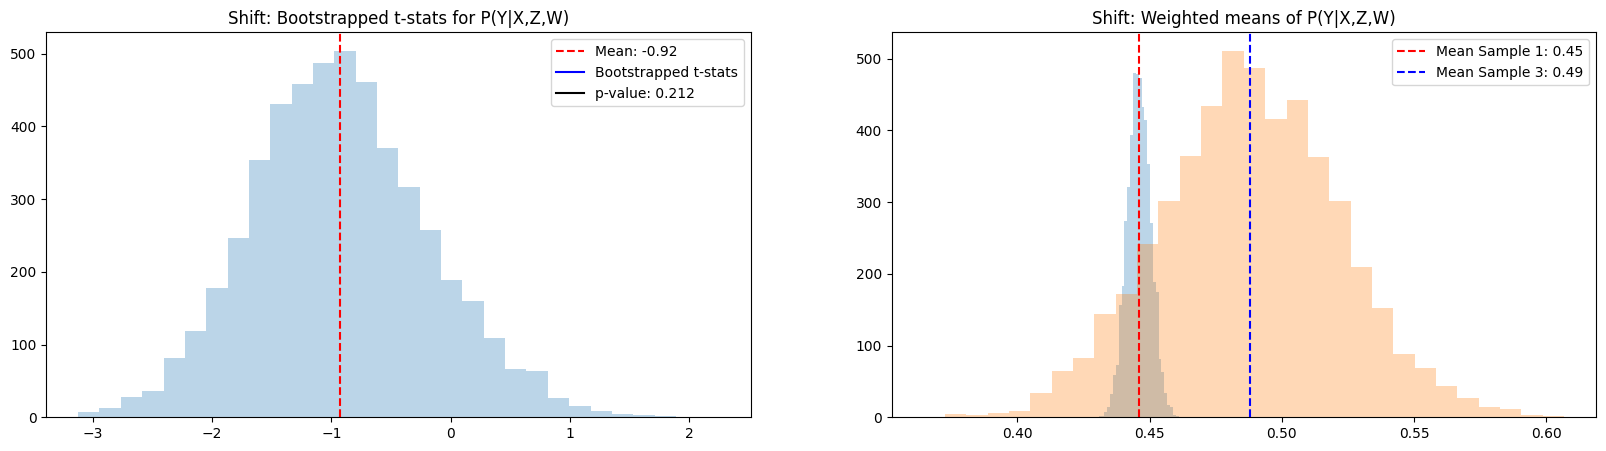

<Figure size 640x480 with 0 Axes>

In [17]:
#Give histogram of t-stats and weighted means for each test
tests = ["P(Y|X,Z,W)"]
t_stats = [shift_t_stats_y]
weighted_means = [weighted_means_y]
p_values = [p_value_y]

fig, axs = plt.subplots(1,2, figsize=(20,5))

for i in range(1):
    axs[0].hist(t_stats[i], bins=30, label='Bootstrapped t-stats', alpha = 0.3)
    axs[0].set_title(f'Shift: Bootstrapped t-stats for {tests[i]}')
    axs[0].axvline(x=np.mean(t_stats[i]), color='r', linestyle='--', label='Mean')
    #Add p-value without color coding
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean: {np.round(np.mean(t_stats[i]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='-', label="Bootstrapped t-stats")]
    axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='black', linestyle='-', label=f'p-value: {np.round(p_values[i],4)}')])
    axs[1].hist(weighted_means[i][0], bins=30, label='Sample 1', alpha = 0.3)
    axs[1].hist(weighted_means[i][1], bins=30, label='Sample 3', alpha = 0.3)
    axs[1].set_title(f'Shift: Weighted means of {tests[i]}')
    axs[1].axvline(x=np.mean(weighted_means[i][0]), color='r', linestyle='--', label='Mean Sample 1')
    axs[1].axvline(x=np.mean(weighted_means[i][1]), color='b', linestyle='--', label='Mean Sample 3')
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean Sample 1: {np.round(np.mean(weighted_means[i][0]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='--', label=f'Mean Sample 3: {np.round(np.mean(weighted_means[i][1]),2)}')]
    axs[1].legend(handles=handles)

plt.show()
plt.tight_layout()

tests = ["P(Y|X,Z,W)"]
t_stats = [shift_t_stats_y_low_n]
weighted_means = [weighted_means_y_low_n]
p_values = [p_value_y_low_n]

fig, axs = plt.subplots(1,2, figsize=(20,5))

for i in range(1):
    axs[0].hist(t_stats[i], bins=30, label='Bootstrapped t-stats', alpha = 0.3)
    axs[0].set_title(f'Shift: Bootstrapped t-stats for {tests[i]}')
    axs[0].axvline(x=np.mean(t_stats[i]), color='r', linestyle='--', label='Mean')
    #Add p-value without color coding
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean: {np.round(np.mean(t_stats[i]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='-', label="Bootstrapped t-stats")]
    axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='black', linestyle='-', label=f'p-value: {np.round(p_values[i],4)}')])
    axs[1].hist(weighted_means[i][0], bins=30, label='Sample 1', alpha = 0.3)
    axs[1].hist(weighted_means[i][1], bins=30, label='Sample 3', alpha = 0.3)
    axs[1].set_title(f'Shift: Weighted means of {tests[i]}')
    axs[1].axvline(x=np.mean(weighted_means[i][0]), color='r', linestyle='--', label='Mean Sample 1')
    axs[1].axvline(x=np.mean(weighted_means[i][1]), color='b', linestyle='--', label='Mean Sample 3')
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean Sample 1: {np.round(np.mean(weighted_means[i][0]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='--', label=f'Mean Sample 3: {np.round(np.mean(weighted_means[i][1]),2)}')]
    axs[1].legend(handles=handles)

plt.show()
plt.tight_layout()

See? Okay, lets turn to equivalence testing!

In [20]:
import warnings
warnings.filterwarnings('ignore')

#Define function to perform weighted bootstrap test
def equiv_weighted_outcomes_bootstrap_test_schrouff(sample_a,sample_b, causal_parents_source,lower_delta, upper_delta, B=10000, split=0.75):

    np.random.seed(36)
    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty((2,B))
    bootstrapped_mean_probabilities = np.empty(B)
    bootstrapped_weights_mean = np.empty((2,B))
    bootstrapped_weighted_outcome = np.empty((2,B))
    bootstrapped_pooled_se = np.empty(B)
    differences = np.empty(B)
    #Step2: perform bootstrap
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
        #Test, for each bootstrap iteration have a different set for weights and testing
        #Step 2.1: Sample with replacement from the weights and testing
        bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
        bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
        bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
        bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

        #Step 2.2: Fit logistic regression model to estimate weights
        ##Pool the samples
        pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
        ##Add sample indicator
        pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
        ##Feature matrix X with intercept
        X = sm.add_constant(pooled_weights[causal_parents_source])
        ##Target vector Y with sample 1 as reference
        Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
        ##Fit logistic regression model
        logit_model = sm.Logit(Y, X).fit(disp=0)
        ##extract weights on testing set
        X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
        X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
        p_a = logit_model.predict(X_a)
        p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
        p_b = logit_model.predict(X_b)
        #Store the mean probability for p_a
        bootstrapped_mean_probabilities[i] = np.mean(p_a)
        if np.any(p_a == 0) or np.any(p_b == 0):
            print('Warning: Zero values in p_a or p_b')
        if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
            print('Warning: Near-zero values in p_a or p_b')
        #Compute the weights
        w_a = 1/p_a
        w_b = 1/p_b
        #Normalize the weights
        w_a_norm = w_a/np.sum(w_a)
        w_b_norm = w_b/np.sum(w_b)
        #Check for nans and infs
        if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
            print('Warning: NaN values in w_a or w_b')
        if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
            print('Warning: Inf values in w_a or w_b')
        #Check for very small values
        if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
            print('Warning: Near-zero values in w_a or w_b')
        
        #Compute hadamard product
        Y_a = bootstrap_sample_a_testing['Y'].values
        Y_b = bootstrap_sample_b_testing['Y'].values
        product_a = w_a_norm.values*Y_a
        product_b = w_b_norm.values*Y_b
        sum_a = np.sum(product_a)
        sum_b = np.sum(product_b)
        difference = sum_a - sum_b
        differences[i] = difference
        #Compute t-statistic against -delta and delta
        bootstrapped_t_stats[0,i] = ttest_1samp(difference, lower_delta, alternative = 'greater')[0]
        bootstrapped_t_stats[1,i] = ttest_1samp(difference, upper_delta, alternative = 'less')[0]
        '''
        together = np.concatenate([product_a,-product_b])
        bootstrapped_t_stats[0,i] = ttest_1samp(together, -delta, alternative = 'greater')[0]
        bootstrapped_t_stats[1,i] = ttest_1samp(together, delta, alternative = 'less')[0]
        '''
        #Compute and store weighted means
        bootstrapped_weighted_outcome[0,i] = np.sum(product_a)
        bootstrapped_weighted_outcome[1,i] = np.sum(product_b)
        #Compute and store mean weights
        bootstrapped_weights_mean[0,i] = np.mean(w_a)
        bootstrapped_weights_mean[1,i] = np.mean(w_b)

    #Compute t-statistic
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    _, p_value_lower = ttest_1samp(differences,lower_delta, alternative = 'greater')
    _, p_value_greater = ttest_1samp(differences, upper_delta, alternative = 'less')
    
    '''
    #Step 3: Compute p-values
    mean_greater = np.mean(bootstrapped_t_stats[0])
    std_greater = np.std(bootstrapped_t_stats[0])
    mean_less = np.mean(bootstrapped_t_stats[1])
    std_less = np.std(bootstrapped_t_stats[1])
    p_value_greater = (2*norm.cdf(-abs((mean_greater)/std_greater)))
    p_value_less = (2*norm.cdf(-abs((mean_less)/std_less)))
    '''
    return bootstrapped_t_stats, p_value_greater, p_value_lower, bootstrapped_weighted_outcome, differences


#Perform the test for sample 1 vs sample 2 and sample 1 vs sample 3
##Let's sample 1 and 2 again
#sample_1, sample_2 = hiring_data(0, n = 20000)
##for y
causal_parents_source_y = ['X','Z','W']
no_shift_equiv_t_stats_y, no_shift_p_value_greater_y,no_shift_p_value_lower_y,no_shift_equiv_weighted_means_y, no_shift_equiv_differences_y = equiv_weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_y,lower_delta =-0.025, upper_delta=0.025 , B = 5000, split = 0.75)
##for w
causal_parents_source_w = ["X","W"]
no_shift_equiv_t_stats_w, no_shift_p_value_greater_w,no_shift_p_value_lower_w,no_shift_equiv_weighted_means_w, no_shift_equiv_differences_w = equiv_weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_w,lower_delta =-0.025, upper_delta=0.025, B = 5000, split = 0.75)
##for x
causal_parents_source_x, causal_parents_source_z  = [], []
no_shift_equiv_t_stats_x, no_shift_p_value_greater_x,no_shift_p_value_lower_x,no_shift_equiv_weighted_means_x, no_shift_equiv_differences_x = equiv_weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_x,lower_delta =-0.025, upper_delta=0.025, B = 5000, split = 0.75)
no_shift_equiv_t_stats_z, no_shift_p_value_greater_z,no_shift_p_value_lower_z,no_shift_equiv_weighted_means_z, no_shift_equiv_differences_z = equiv_weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source_z,lower_delta =-0.025, upper_delta=0.025, B = 5000, split = 0.75)


Bootstrapping: 100%|██████████| 5000/5000 [02:26<00:00, 34.15it/s]


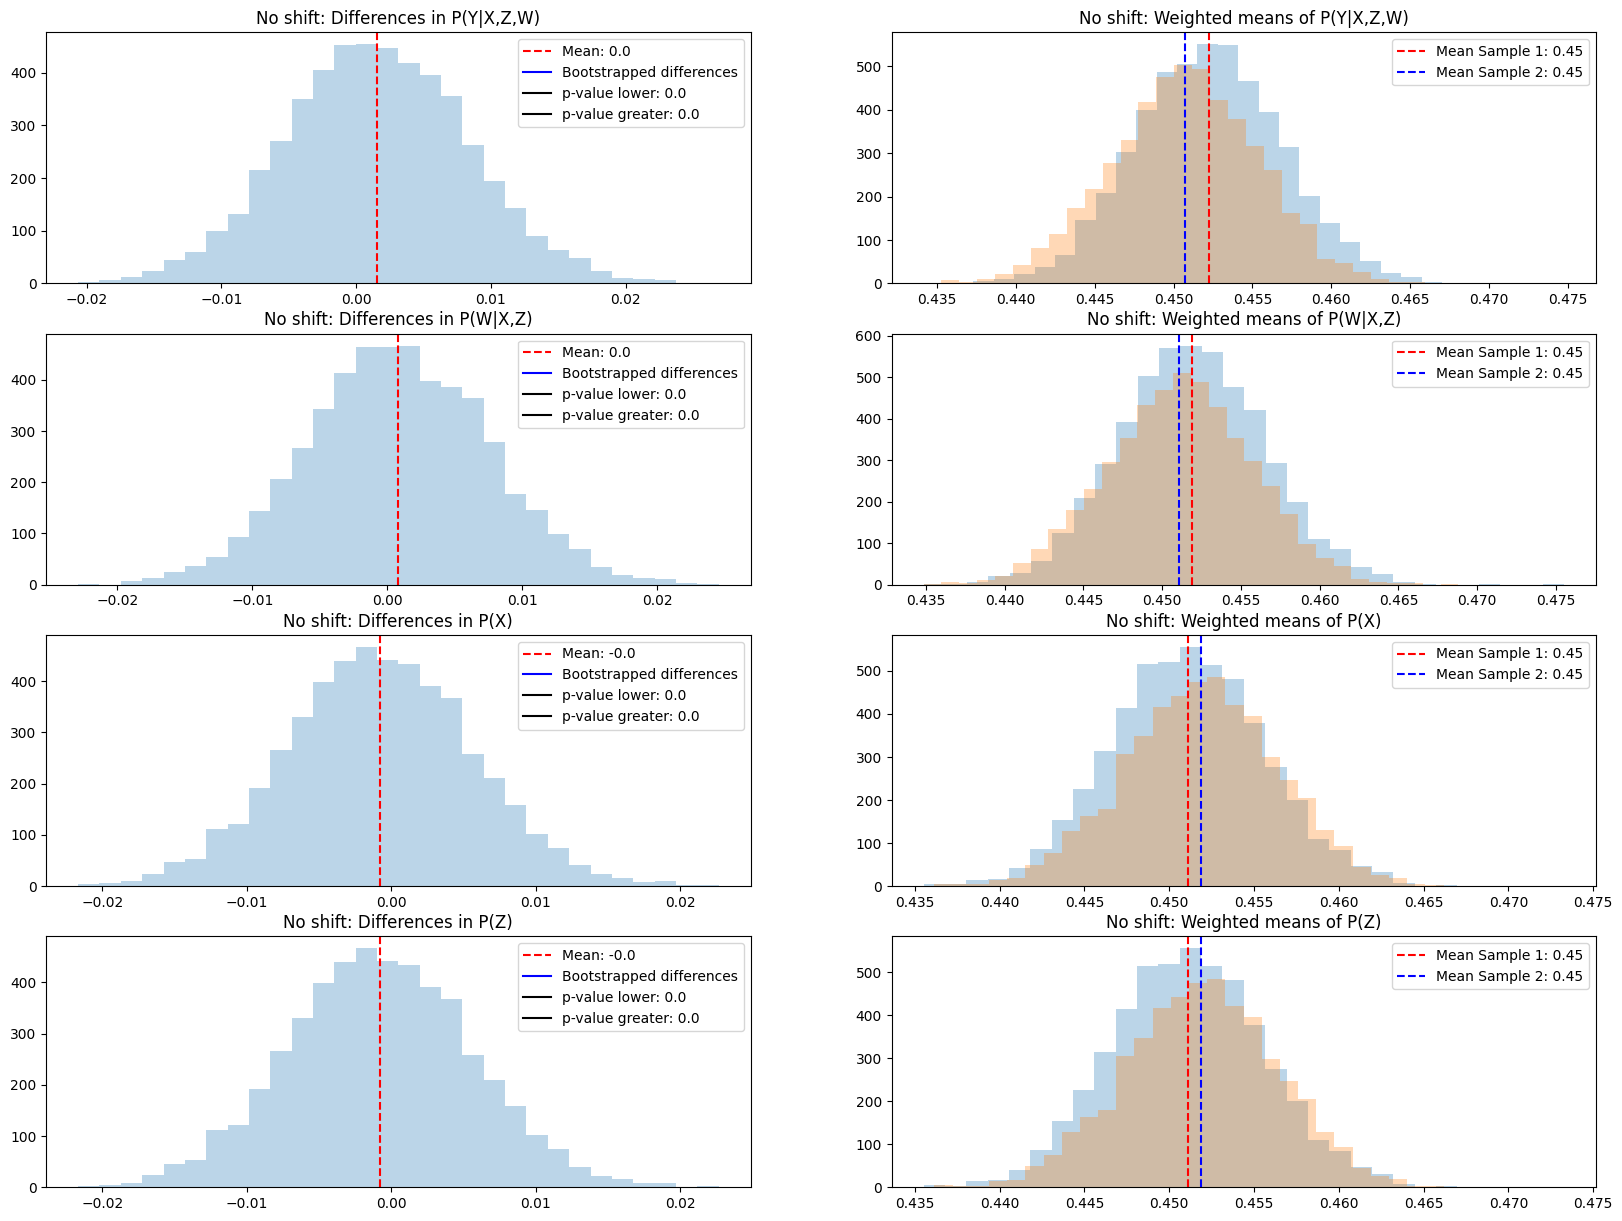

<Figure size 640x480 with 0 Axes>

In [21]:
#Give histogram of the differences and weighted means for each test
tests = ["P(Y|X,Z,W)", "P(W|X,Z)", "P(X)", "P(Z)"]
differences = [no_shift_equiv_differences_y, no_shift_equiv_differences_w, no_shift_equiv_differences_x, no_shift_equiv_differences_z]
weighted_means = [no_shift_equiv_weighted_means_y, no_shift_equiv_weighted_means_w, no_shift_equiv_weighted_means_x, no_shift_equiv_weighted_means_z]
p_values_lower = [no_shift_p_value_lower_y, no_shift_p_value_lower_w, no_shift_p_value_lower_x, no_shift_p_value_lower_z]
p_values_greater = [no_shift_p_value_greater_y, no_shift_p_value_greater_w, no_shift_p_value_greater_x, no_shift_p_value_greater_z]

fig, axs = plt.subplots(4,2, figsize=(20,15))
for i in range(4):
    axs[i,0].hist(differences[i], bins=30, label='Bootstrapped differences', alpha = 0.3)
    axs[i,0].set_title(f'No shift: Differences in {tests[i]}')
    axs[i,0].axvline(x=np.mean(differences[i]), color='r', linestyle='--', label='Mean')
    #Add p-value without color coding
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean: {np.round(np.mean(differences[i]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='-', label="Bootstrapped differences")]
    axs[i,0].legend(handles=handles + [plt.Line2D([0], [0], color='black', linestyle='-', label=f'p-value lower: {np.round(p_values_lower[i],4)}'),
                                     plt.Line2D([0], [0], color='black', linestyle='-', label=f'p-value greater: {np.round(p_values_greater[i],4)}')])
    axs[i,1].hist(weighted_means[i][0], bins=30, label='Sample 1', alpha = 0.3)
    axs[i,1].hist(weighted_means[i][1], bins=30, label='Sample 2', alpha = 0.3)
    axs[i,1].set_title(f'No shift: Weighted means of {tests[i]}')
    axs[i,1].axvline(x=np.mean(weighted_means[i][0]), color='r', linestyle='--', label='Mean Sample 1')
    axs[i,1].axvline(x=np.mean(weighted_means[i][1]), color='b', linestyle='--', label='Mean Sample 2')
    handles = [plt.Line2D([0], [0], color='r', linestyle='--', label=f'Mean Sample 1: {np.round(np.mean(weighted_means[i][0]),2)}'),
                plt.Line2D([0], [0], color='b', linestyle='--', label=f'Mean Sample 2: {np.round(np.mean(weighted_means[i][1]),2)}')]
    axs[i,1].legend(handles=handles)

plt.show()
plt.tight_layout()


In [ ]:
#Perform the test for distribution shifts for each subcondtional between sample 1 and sample 2
#combinations of X,Z,W for P(Y|X,Z,W)
##for y





Bootstrapping:   0%|          | 0/5000 [00:00<?, ?it/s]


LinAlgError: Singular matrix